In [38]:
# Importing packages
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

# Setting the project directory
project_dir = Path('./')

In [39]:
date_vars = ['DatetimeBegin','DatetimeEnd']

agg_ts = pd.read_csv(project_dir / 'RO_1_2013-2015_aggregated_timeseries.csv', sep='\t', parse_dates=date_vars, date_parser=pd.to_datetime)
meta = pd.read_csv(project_dir / 'RO_2013-2015_metadata.csv', sep='\t')

print('aggregated timeseries shape:{}'.format(agg_ts.shape))
print('metadata shape:{}'.format(meta.shape))

aggregated timeseries shape:(67215, 18)
metadata shape:(561, 26)


In [40]:
pandas_profiling.ProfileReport(agg_ts)


Number of variables,18
Number of observations,67215
Total Missing (%),0.0%
Total size in memory,9.2 MiB
Average record size in memory,144.0 B
Numeric,3
Categorical,6
Boolean,0
Date,2
Text (Unique),0
Rejected,7


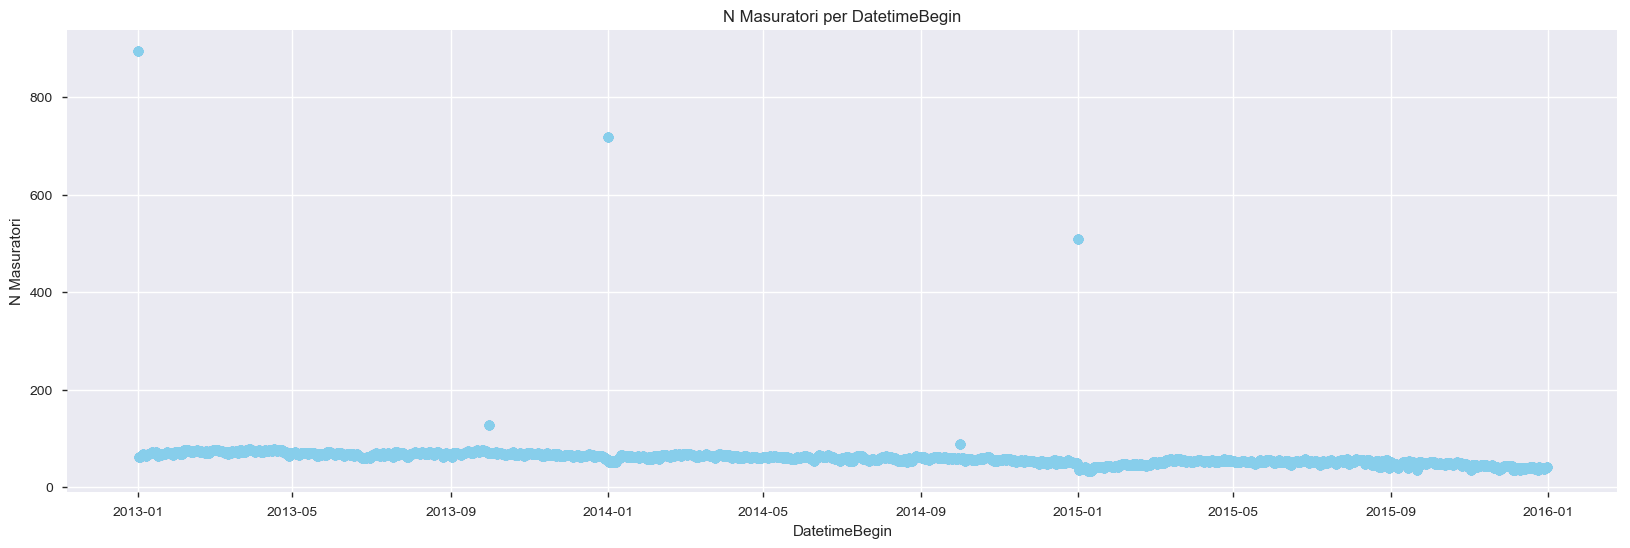

In [41]:
plt.figure(figsize=(20,6))
plt.plot(agg_ts.groupby('DatetimeBegin').count(), 'o', color='skyblue')
plt.title('N Masuratori per DatetimeBegin')
plt.ylabel('N Masuratori')
plt.xlabel('DatetimeBegin')
plt.show()

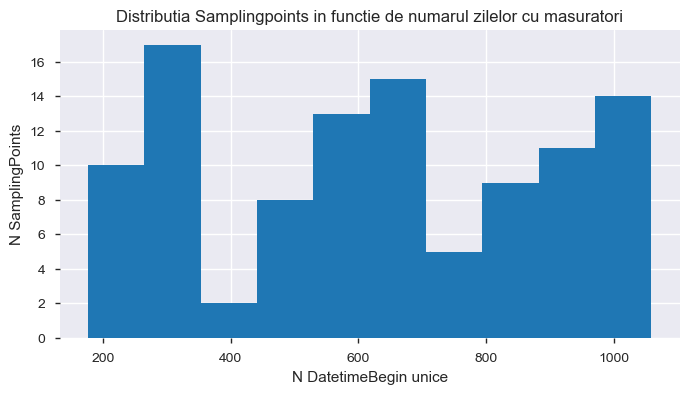

In [42]:
ser_avail_days = agg_ts.groupby('SamplingPoint').nunique()['DatetimeBegin']
plt.figure(figsize=(8,4))
plt.hist(ser_avail_days.sort_values(ascending=False))
plt.ylabel('N SamplingPoints')
plt.xlabel('N DatetimeBegin unice')
plt.title('Distributia Samplingpoints in functie de numarul zilelor cu masuratori')
plt.show()

In [43]:
df = agg_ts.loc[agg_ts.DataAggregationProcess=='P1D', :] 
df = df.loc[df.UnitOfAirPollutionLevel!='count', :]
df = df.loc[df.SamplingPoint.isin(ser_avail_days[ser_avail_days.values >= 1000].index), :]
vars_to_drop = ['AirPollutant','AirPollutantCode','Countrycode','Namespace','TimeCoverage','Validity','Verification','AirQualityStation',
               'AirQualityStationEoICode','DataAggregationProcess','UnitOfAirPollutionLevel', 'DatetimeEnd', 'AirQualityNetwork',
               'DataCapture', 'DataCoverage']
df.drop(columns=vars_to_drop, axis='columns', inplace=True)

In [44]:
dates = list(pd.period_range(min(df.DatetimeBegin), max(df.DatetimeBegin), freq='D').values)
samplingpoints = list(df.SamplingPoint.unique())

new_idx = []
for sp in samplingpoints:
    for d in dates:
        new_idx.append((sp, np.datetime64(d)))

df.set_index(keys=['SamplingPoint', 'DatetimeBegin'], inplace=True)
df.sort_index(inplace=True)
df = df.reindex(new_idx)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # should contain NaN for the columns

df['AirPollutionLevel'] = df.groupby(level=0).AirPollutionLevel.bfill().fillna(0)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # NaN are replaced by values of 2013-01-30
print('{} missing values'.format(df.isnull().sum().sum()))

0 missing values


In [45]:
df = df.loc['SPO-RO0076A_00001_100',:]
print(df.shape)

(1095, 1)


In [46]:
train = df.query('DatetimeBegin < "2014-07-01"')
valid = df.query('DatetimeBegin >= "2014-07-01" and DatetimeBegin < "2015-01-01"')
test = df.query('DatetimeBegin >= "2015-01-01"')

In [47]:
# Save column names and indices to use when storing as csv
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
valid = scaler.transform(valid)
test = scaler.transform(test)

In [48]:
train = pd.DataFrame(train, columns=cols, index=train_idx)
valid = pd.DataFrame(valid, columns=cols, index=valid_idx)
test = pd.DataFrame(test, columns=cols, index=test_idx)

train.to_csv('train.csv')
valid.to_csv('valid.csv')
test.to_csv('test.csv')

In [49]:
train = pd.read_csv('train.csv', header=0, index_col=0).values.astype('float32')
valid = pd.read_csv('valid.csv', header=0, index_col=0).values.astype('float32')
test = pd.read_csv('test.csv', header=0, index_col=0).values.astype('float32')

def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Epoci')
    plt.ylabel('Pierdere')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [57]:
n_lag = 10

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 3)
valid_data_gen = TimeseriesGenerator(valid, valid, length=n_lag, sampling_rate=1, stride=1, batch_size = 3)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=1, batch_size = 3)

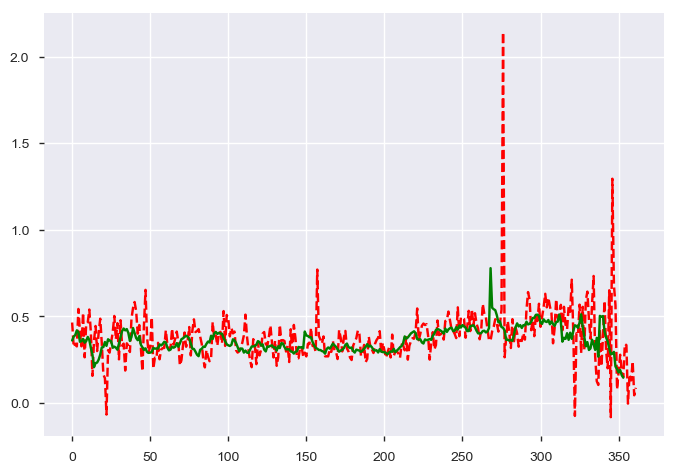

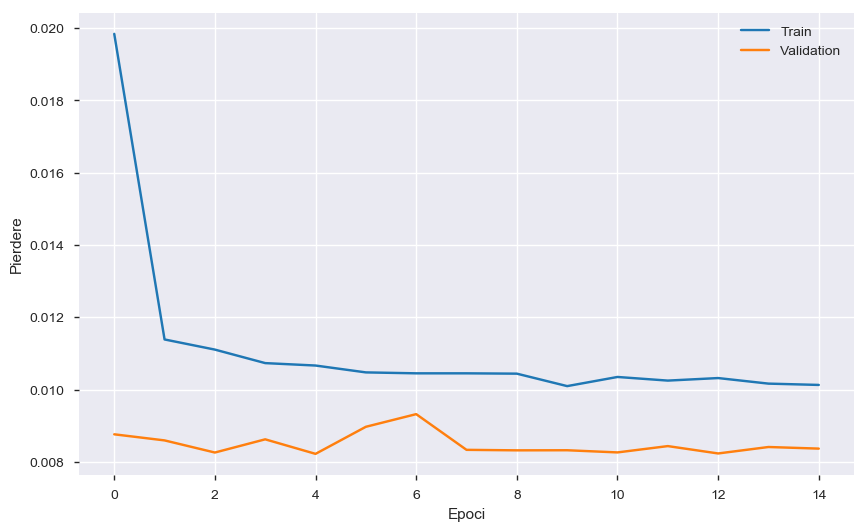

Minimum validation loss of 0.008218893108905518 reached at epoch 4


In [58]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(4, input_shape=(n_lag, 1)))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mean_squared_error', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='simple_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("simple_lstm.json", "w") as m:
    m.write(simple_lstm.to_json())

simple_lstm_history = simple_lstm.fit_generator(train_data_gen
                        
                                                , epochs=150
                                                , validation_data=valid_data_gen
                                                , verbose=0
                                                , callbacks=[checkpointer, earlystopper])

output = simple_lstm.evaluate_generator(test_data_gen)
output = simple_lstm.predict_generator(test_data_gen)
y_pred = simple_lstm.predict_generator(valid_data_gen)
#print(mean_squared_error(y_pred,Y_valid))
plt.plot(Y_test[:-1], color="red", linestyle="dashed")
plt.plot(output[1:], color="green")

plot_loss(simple_lstm_history, '')

[[0.34598434]
 [0.4298232 ]
 [0.37944305]
 [0.33924404]
 [0.33525172]
 [0.32177114]
 [0.3906258 ]
 [0.3750713 ]
 [0.31663814]
 [0.37849328]
 [0.36231658]
 [0.27059677]
 [0.3050194 ]
 [0.31705293]
 [0.49235237]
 [0.3855965 ]
 [0.2601234 ]
 [0.37688598]
 [0.28578836]
 [0.41634262]
 [0.57448024]
 [0.45719916]
 [0.2712708 ]
 [0.39990667]
 [0.3359776 ]
 [0.32099342]
 [0.2793073 ]
 [0.39754757]
 [0.32094157]
 [0.32405248]
 [0.41940168]
 [0.42443097]
 [0.31191996]
 [0.37372324]
 [0.34811014]
 [0.27687043]
 [0.46502826]
 [0.30289832]
 [0.35962048]
 [0.35422823]
 [0.33058536]
 [0.32114896]
 [0.27998134]
 [0.40384716]
 [0.37040493]
 [0.38124126]
 [0.3049204 ]
 [0.29885414]
 [0.33442214]
 [0.42106083]
 [0.3736431 ]
 [0.3973661 ]
 [0.3589983 ]
 [0.33219266]
 [0.352258  ]
 [0.4359413 ]
 [0.34235495]
 [0.35625032]
 [0.31523824]
 [0.3537616 ]
 [0.3716493 ]
 [0.37543422]
 [0.42505315]
 [0.4607767 ]
 [0.5067662 ]
 [0.45123658]
 [0.2505833 ]
 [0.43837819]
 [0.4135428 ]
 [0.4344377 ]
 [0.3624203 ]
 [0.42

c:\users\domnul cristian\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


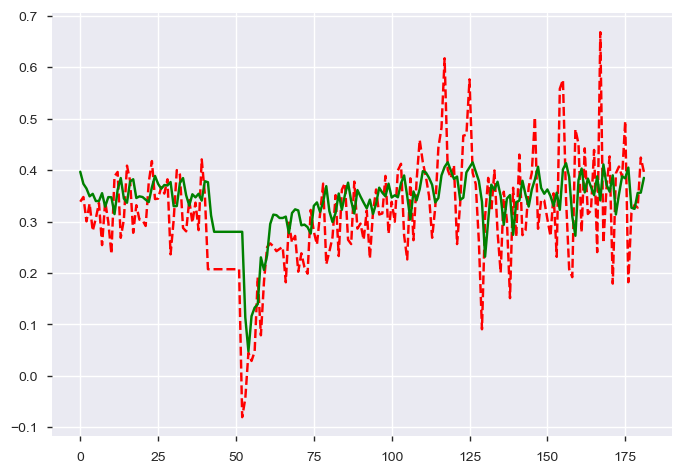

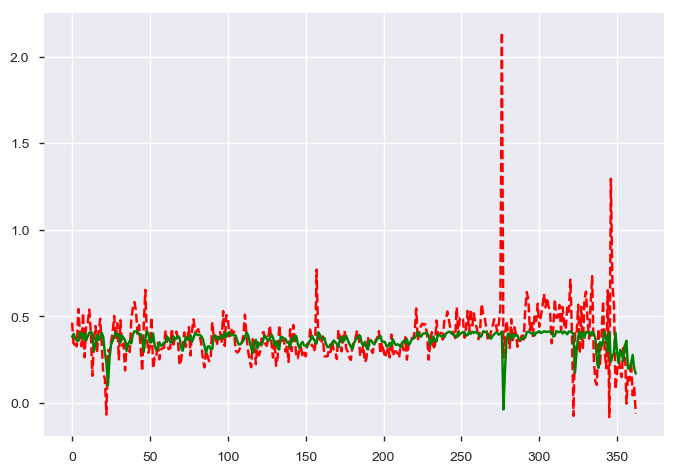

In [52]:
from sklearn import svm
from sklearn.metrics import mean_squared_error
print(train)
X_train = np.zeros((train.shape[0]-2,2))
X_train[:,0] = train[0:-2,0]
X_train[:,1] = train[1:-1,0]
Y_train = [train[i+2] for i,_ in enumerate(train[:-2])]
print(X_train[:10,:])
print(Y_train[:10])
X_valid = np.zeros((valid.shape[0]-2,2))
X_valid[:,0] = valid[0:-2,0]
X_valid[:,1] = valid[1:-1,0]
Y_valid = [valid[i+2] for i,_ in enumerate(valid[:-2])]

X_test = np.zeros((test.shape[0]-2,2))
X_test[:,0] = test[0:-2,0]
X_test[:,1] = test[1:-1,0]
Y_test = [test[i+2] for i,_ in enumerate(test[:-2])]

clf = svm.SVR(kernel = "rbf", gamma = 0.52, verbose = True)
res = clf.fit(X_train, Y_train)
y_pred = clf.predict(X_valid)
print(mean_squared_error(y_pred,Y_valid))
plt.plot(Y_valid,color="red", linestyle='dashed')
plt.plot(y_pred,color="green")
plt.figure()
y_pred = clf.predict(X_test)
plt.plot(Y_test,color="red", linestyle='dashed')
plt.plot(y_pred,color="green")

0.0092664305


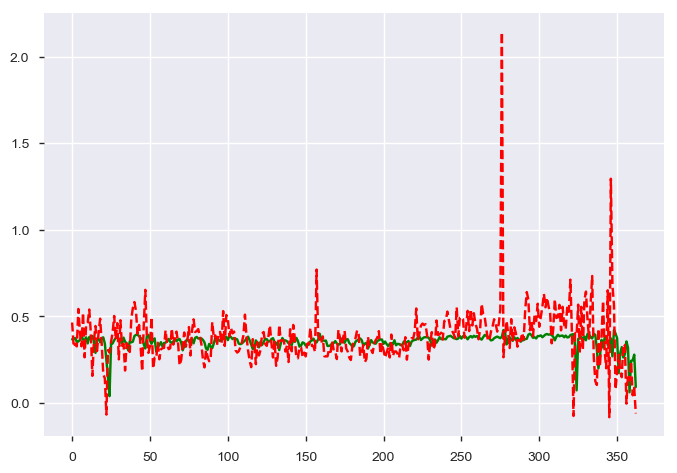

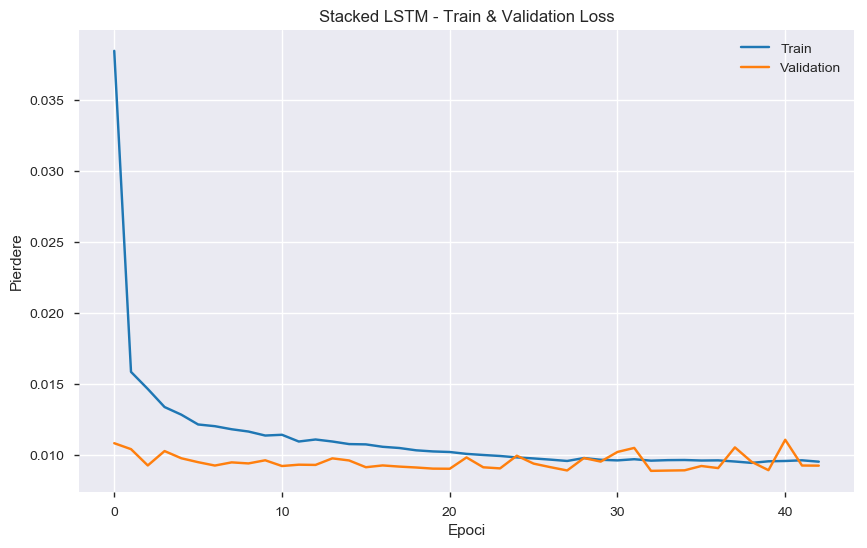

Minimum validation loss of 0.00889927717167206 reached at epoch 32


In [53]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(n_lag, 1), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mean_squared_error', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./stacked_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./stacked_lstm.json", "w") as m:
    m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit_generator(train_data_gen
                                                  , epochs=100
                                                  , validation_data=valid_data_gen
                                                  , verbose=0
                                                  , callbacks=[checkpointer, earlystopper])

output = stacked_lstm.predict_generator(test_data_gen)
y_pred = stacked_lstm.predict_generator(valid_data_gen)
print(mean_squared_error(y_pred,Y_valid))
plt.plot(output, color="green")
plt.plot(Y_test, color="red", linestyle="dashed")
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')

c:\users\domnul cristian\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\users\domnul cristian\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\domnul cristian\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


{'max_depth': 6, 'n_estimators': 100}


c:\users\domnul cristian\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\domnul cristian\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\domnul cristian\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\domn

-0.009813833576066522
0.008926648147321798


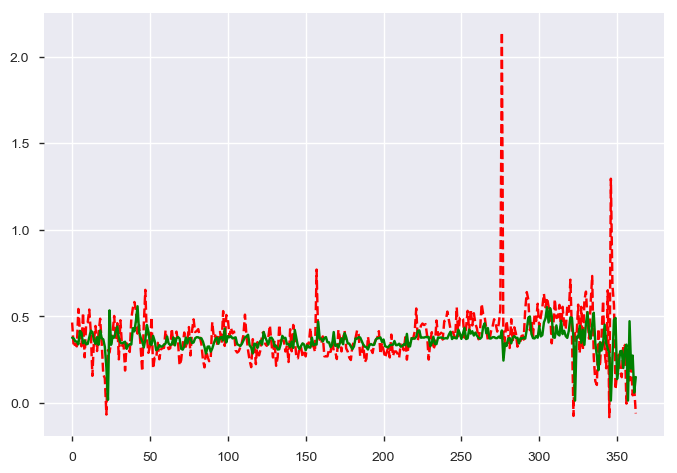

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    print(best_params)
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_squared_error')
    rfr.fit(X,y)
    print(scores.mean())
    return rfr
rf_m = rfr_model(X_train,Y_train)
y_pred = rf_m.predict(X_valid)
print(mean_squared_error(y_pred,Y_valid))
y_pred = rf_m.predict(X_test)

plt.plot(Y_test,color="red", linestyle='dashed')
plt.plot(y_pred,color="green")


0.011839921


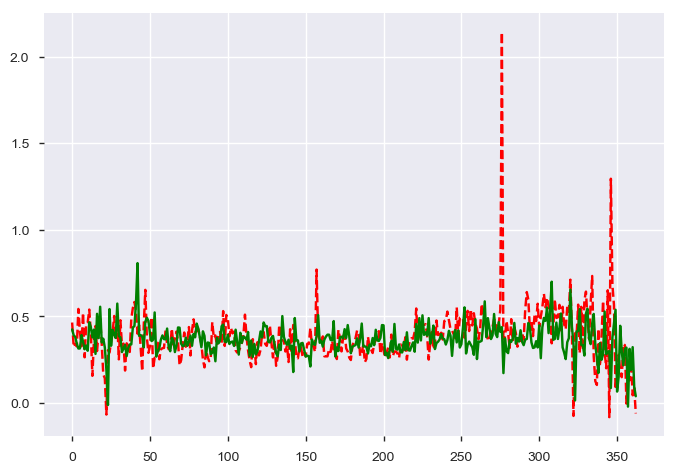

In [55]:
import xgboost

xgb = xgboost.XGBRegressor(n_estimators=50, learning_rate=0.3, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6).fit(X_train,Y_train)
y_pred = xgb.predict(X_test)
y_valid_pred = xgb.predict(X_valid)
plt.plot(Y_test,color="red", linestyle='dashed')
plt.plot(y_pred,color="green")
print(mean_squared_error(y_valid_pred, Y_valid))